# **Mango🥭 Leaf🍃🍂 Disease**

## **Install & Import Library**

In [1]:
!pip install opendatasets pillow matplotlib seaborn scikit-learn
!pip install opendatasets kaggle
!pip install tensorflow

In [42]:
# Import library yang diperlukan
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import opendatasets as od
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB5
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
from google.colab import files
import pickle
warnings.filterwarnings('ignore')

## **Pengumpulan Data**

In [3]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
# Set matplotlib style
plt.style.use('ggplot')

In [5]:
#DOWNLOAD DATASET
dataset_url = "https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset"
od.download(dataset_url)
# Verifikasi path
dataset_path = "/content/mango-leaf-disease-dataset"
print("Isi folder dataset:")
print(os.listdir(dataset_path))


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: permataa
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset


100%|██████████| 103M/103M [00:00<00:00, 965MB/s] 

Isi folder dataset:
['Gall Midge', 'Powdery Mildew', 'Healthy', 'Cutting Weevil', 'Anthracnose', 'Bacterial Canker', 'Sooty Mould', 'Die Back']


In [6]:
# Path langsung ke dataset
dataset_path = "/content/mango-leaf-disease-dataset"
print("Isi folder dataset:")
print(os.listdir(dataset_path))

Isi folder dataset:
['Gall Midge', 'Powdery Mildew', 'Healthy', 'Cutting Weevil', 'Anthracnose', 'Bacterial Canker', 'Sooty Mould', 'Die Back']


## EDA

In [7]:
# Daftar kelas penyakit
class_names = sorted(['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back',
                     'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould'])


In [8]:
# Hitung jumlah gambar per kelas
class_counts = {}
for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

print(class_counts)


{'Anthracnose': 500, 'Bacterial Canker': 500, 'Cutting Weevil': 500, 'Die Back': 500, 'Gall Midge': 500, 'Healthy': 500, 'Powdery Mildew': 500, 'Sooty Mould': 500}


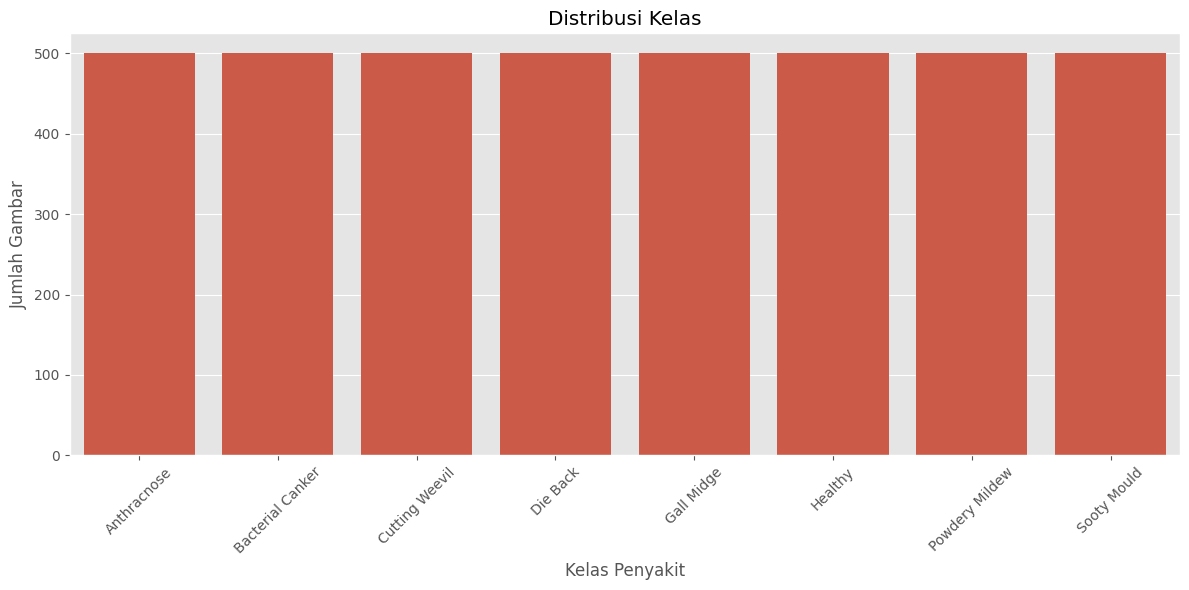

In [9]:
# Plot distribusi kelas
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Distribusi Kelas")
plt.ylabel("Jumlah Gambar")
plt.xlabel("Kelas Penyakit")
plt.tight_layout()
plt.show()

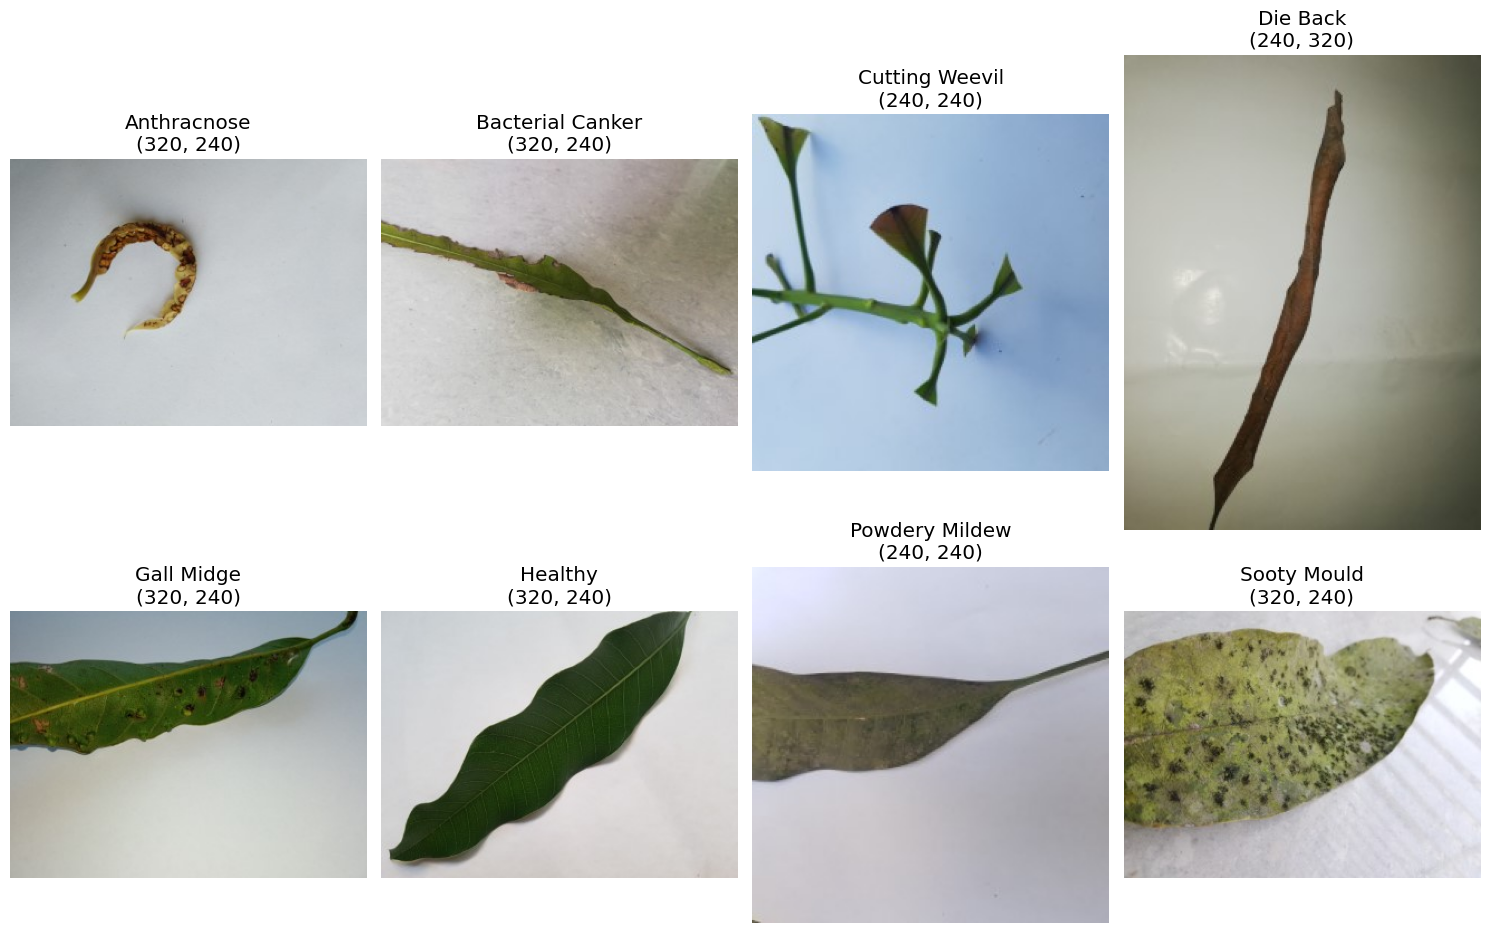

In [10]:
# Contoh gambar per kelas
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(class_names):
    img_path = os.path.join(dataset_path, class_name, os.listdir(os.path.join(dataset_path, class_name))[0])
    img = Image.open(img_path)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(f"{class_name}\n{img.size}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Preprocessing data

In [ ]:
# # Parameter
# IMG_SIZE = (224, 224)  
# BATCH_SIZE = 32
# VAL_SPLIT = 0.15
# TEST_SPLIT = 0.15

In [12]:
# preprocessing untuk EfficientNet
train_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess,
    validation_split=0.2
)

In [13]:
# Membuat generator untuk data training dan validation
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3200 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


## MOdel

In [14]:
# Membuat model EfficientNetB4 (bisa diganti ke B5 jika diperlukan)
def create_efficientnet_model(input_shape=(224, 224, 3), num_classes=8):
    # Menggunakan EfficientNetB4 dengan weights ImageNet, include_top=False untuk custom classifier
    base_model = EfficientNetB4(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling=None
    )

    # Freeze layer dasar untuk transfer learning
    base_model.trainable = False

    # Membangun model lengkap
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    return model


In [15]:
# Membuat model
model = create_efficientnet_model()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [16]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks untuk mencegah overfitting dan menyimpan model terbaik
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

In [17]:
model_checkpoint = ModelCheckpoint(
    'best_model_efficientnet.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [18]:
# Training model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Evaluasi model
test_loss, test_acc = model.evaluate(val_generator)
print(f'Test accuracy: {test_acc:.4f}')

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.4737 - loss: 1.5804

100/100 ━━━━━━━━━━━━━━━━━━━━ 100s 526ms/step - accuracy: 0.4756 - loss: 1.5764 - val_accuracy: 0.8612 - val_loss: 0.6341 - learning_rate: 1.0000e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8684 - loss: 0.5774

100/100 ━━━━━━━━━━━━━━━━━━━━ 49s 434ms/step - accuracy: 0.8685 - loss: 0.5767 - val_accuracy: 0.9175 - val_loss: 0.3722 - learning_rate: 1.0000e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9125 - loss: 0.3426

100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 438ms/step - accuracy: 0.9126 - loss: 0.3423 - val_accuracy: 0.9325 - val_loss: 0.2758 - learning_rate: 1.0000e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9395 - loss: 0.2388

100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 423ms/step - accuracy: 0.9395 - loss: 0.2387 - val_accuracy: 0.9400 - val_loss: 0.2305 - learning_rate: 1.0000e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9477 - loss: 0.2057

100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 422ms/step - accuracy: 0.9477 - loss: 0.2056 - val_accuracy: 0.9450 - val_loss: 0.2010 - learning_rate: 1.0000e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 416ms/step - accuracy: 0.9561 - loss: 0.1704 - val_accuracy: 0.9362 - val_loss: 0.1902 - learning_rate: 1.0000e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9518 - loss: 0.1610

100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 423ms/step - accuracy: 0.9518 - loss: 0.1609 - val_accuracy: 0.9625 - val_loss: 0.1476 - learning_rate: 1.0000e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 414ms/step - accuracy: 0.9662 - loss: 0.1355 - val_accuracy: 0.9563 - val_loss: 0.1461 - learning_rate: 1.0000e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 417ms/step - accuracy: 0.9661 - loss: 0.1275 - val_accuracy: 0.9575 - val_loss: 0.1356 - learning_rate: 1.0000e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9729 - loss: 0.1030

100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 426ms/step - accuracy: 0.9729 - loss: 0.1030 - val_accuracy: 0.9638 - val_loss: 0.1238 - learning_rate: 1.0000e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9770 - loss: 0.0915

100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 441ms/step - accuracy: 0.9770 - loss: 0.0915 - val_accuracy: 0.9688 - val_loss: 0.1126 - learning_rate: 1.0000e-04
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9775 - loss: 0.0841

100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 420ms/step - accuracy: 0.9775 - loss: 0.0841 - val_accuracy: 0.9700 - val_loss: 0.1009 - learning_rate: 1.0000e-04
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9781 - loss: 0.0767

100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 432ms/step - accuracy: 0.9781 - loss: 0.0767 - val_accuracy: 0.9725 - val_loss: 0.0996 - learning_rate: 1.0000e-04
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 429ms/step - accuracy: 0.9769 - loss: 0.0707 - val_accuracy: 0.9712 - val_loss: 0.0987 - learning_rate: 1.0000e-04
Epoch 15/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 416ms/step - accuracy: 0.9854 - loss: 0.0620 - val_accuracy: 0.9700 - val_loss: 0.0971 - learning_rate: 1.0000e-04
Epoch 16/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 412ms/step - accuracy: 0.9815 - loss: 0.0713 - val_accuracy: 0.9700 - val_loss: 0.1038 - learning_rate: 1.0000e-04
Epoch 17/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 418ms/step - accuracy: 0.9866 - loss: 0.0584 - val_accuracy: 0.9712 - val_loss: 0.0881 - learning_rate: 1.0000e-04
Epoch 18/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 416ms/step - accuracy: 0.9912 - loss: 0.0535 - val_accuracy: 0.9712 - val_loss: 0.0918 - learning_rate: 1.0000e-04
Epoch 19/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 425ms/s

100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 427ms/step - accuracy: 0.9908 - loss: 0.0411 - val_accuracy: 0.9762 - val_loss: 0.0763 - learning_rate: 1.0000e-04
Epoch 26/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 425ms/step - accuracy: 0.9931 - loss: 0.0378 - val_accuracy: 0.9737 - val_loss: 0.0794 - learning_rate: 1.0000e-04
Epoch 27/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 425ms/step - accuracy: 0.9907 - loss: 0.0380 - val_accuracy: 0.9688 - val_loss: 0.0773 - learning_rate: 1.0000e-04
Epoch 28/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 421ms/step - accuracy: 0.9859 - loss: 0.0452 - val_accuracy: 0.9712 - val_loss: 0.0725 - learning_rate: 1.0000e-04
Epoch 29/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 423ms/step - accuracy: 0.9915 - loss: 0.0357 - val_accuracy: 0.9762 - val_loss: 0.0712 - learning_rate: 1.0000e-04
Epoch 30/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 427ms/step - accuracy: 0.9910 - loss: 0.0377 - val_accuracy: 0.9737 - val_loss: 0.0743 - learning_rate: 1.0000e-04
Epoch 31/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 428ms/s

100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 426ms/step - accuracy: 0.9947 - loss: 0.0237 - val_accuracy: 0.9775 - val_loss: 0.0613 - learning_rate: 1.0000e-04
Epoch 38/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 428ms/step - accuracy: 0.9925 - loss: 0.0319 - val_accuracy: 0.9775 - val_loss: 0.0665 - learning_rate: 1.0000e-04
Epoch 39/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9949 - loss: 0.0217

100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 427ms/step - accuracy: 0.9949 - loss: 0.0217 - val_accuracy: 0.9787 - val_loss: 0.0606 - learning_rate: 1.0000e-04
Epoch 40/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 426ms/step - accuracy: 0.9915 - loss: 0.0270 - val_accuracy: 0.9700 - val_loss: 0.0719 - learning_rate: 1.0000e-04
Epoch 41/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 425ms/step - accuracy: 0.9947 - loss: 0.0268 - val_accuracy: 0.9775 - val_loss: 0.0628 - learning_rate: 1.0000e-04
Epoch 42/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 416ms/step - accuracy: 0.9939 - loss: 0.0227 - val_accuracy: 0.9725 - val_loss: 0.0636 - learning_rate: 1.0000e-04
Epoch 43/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 425ms/step - accuracy: 0.9931 - loss: 0.0252 - val_accuracy: 0.9725 - val_loss: 0.0620 - learning_rate: 1.0000e-04
Epoch 44/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 423ms/step - accuracy: 0.9905 - loss: 0.0282 - val_accuracy: 0.9775 - val_loss: 0.0651 - learning_rate: 1.0000e-04
Epoch 45/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 424ms/s

## Evaluasi

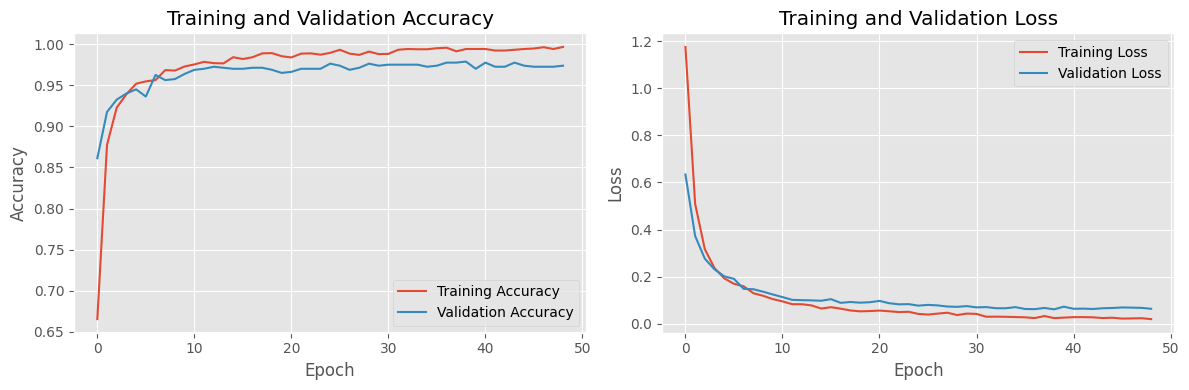

In [19]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# Classification report
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

print(classification_report(y_true, y_pred_classes, target_names=class_names))


25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step
                  precision    recall  f1-score   support

     Anthracnose       0.06      0.06      0.06       100
Bacterial Canker       0.11      0.11      0.11       100
  Cutting Weevil       0.08      0.08      0.08       100
        Die Back       0.12      0.12      0.12       100
      Gall Midge       0.08      0.08      0.08       100
         Healthy       0.15      0.15      0.15       100
  Powdery Mildew       0.14      0.15      0.15       100
     Sooty Mould       0.17      0.16      0.16       100

        accuracy                           0.11       800
       macro avg       0.11      0.11      0.11       800
    weighted avg       0.11      0.11      0.11       800



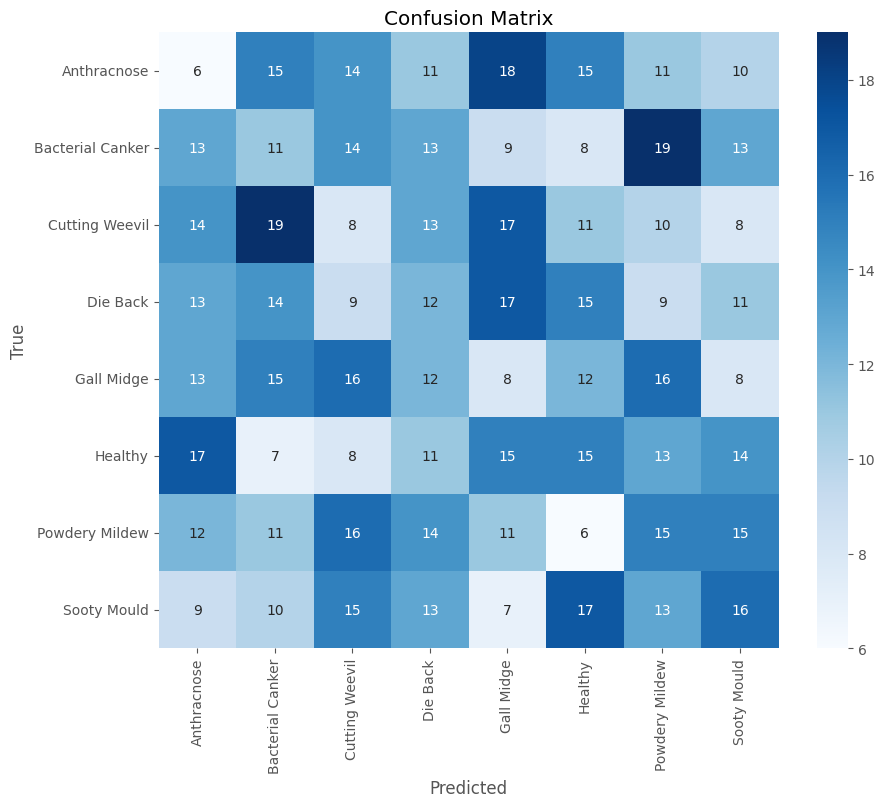

In [21]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [33]:
# Analisis overfitting
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)

print(f'Train Accuracy: {train_acc*100:.2f}%')
print(f'Validation Accuracy: {val_acc*100:.2f}%')
print(f'Test Accuracy: {test_acc*100:.2f}%')

100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 395ms/step - accuracy: 0.9961 - loss: 0.0149
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9831 - loss: 0.0506
Train Accuracy: 99.75%
Validation Accuracy: 97.87%
Test Accuracy: 97.87%


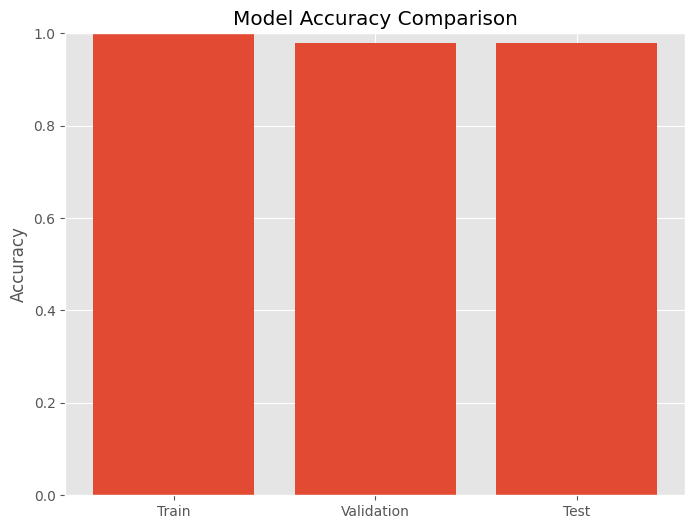

In [34]:
# Plot perbandingan akurasi
plt.figure(figsize=(8,6))
plt.bar(['Train', 'Validation', 'Test'], [train_acc, val_acc, test_acc])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

## Save model konfersi

In [39]:
# Simpan model ke format HDF5 (.h5)
model.save("mangalyze_model.h5")

In [41]:

# Simpan model menggunakan pickle
with open("mangalyze_model.pkl", "wb") as f:
    pickle.dump(model, f)


In [46]:
model.save("mangalyze_model.keras")

In [44]:
files.download('mangalyze_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
files.download('mangalyze_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
files.download('mangalyze_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>